# HW #3 - Pima Indian Diabetes Analysis - Revisited
- Jim Haskin
- GA-Data Science
- Dec 2015
- 2/29/2016

## Assignment
- 1 - Give an overall summary of your performance from HW2 on the dataset
- 2 - Do you see any areas for improvement?
- 3 - Run k-Means on the dataset and describe your results
- 4 - Run PCA on the dataset and describe your results
- 5 - Use the cluster outputs you got from running k-means as a new feature. Rerun your "worst" and "best" model from HW2, including this new feature along with your old features. Describe your results.
- 6 - Use the PCA outputs you got from running PCA above as your features. Rerun your "worst" and "best" model from HW2, with the PCA features instead of your old features. Describe your results.
- 7 - Give your conclusions on the use of k-Means and PCA on the Diabetes dataset

## 1 - Give an overall summary of your performance from HW2 on the dataset
Below is the chart I had for the final run of Homework # 2


3nd run add back insulin|model|recall|precision|f1|accuracy|time|LC comments
------------|-----|------|---------|--|--------|----|-----------
add 3 halos|knn	|0.655172	|0.678571	|0.666667	|0.748344	|2450.51	|slight varience, Traing up to 100%
Tuning-recall|logreg	|0.810345	|0.671429	|0.734375	|0.774834	|33.3404	|low variance. score ~65. 5% gap
|nb	|0.724138	|0.666667	|0.694215	|0.615894	|104.664	|low variance. score ~60. 5pt gap between train...
|rf	|0.562718	|0.76087	|0.673077	|0.562718	|4892.99	|very slight variance.

- Adding in the three halo effect brought up the recall scores of all models. 
- Random Forest was still laging behind.
- knn and Logreg both beat the accuracy score of just picking no (65%) by about 10%, but recall scores were quite different.

## 2 - Do you see any areas for improvement?




#### Scoring / BenchMark
- I might switch to an F1 score. Normally for cancer you would be very concerned with the False Negatives, but since this is such a strange case (rates much higher than normal population) might want to see a more general scoring.
- Should use a dummy classifier to get a better idea of the dummy score for recall and f1. Just looking at accuracy is not enough info. Not sure I really did any better.

#### Features
- Should spend more time looking at features.
- Maybe add more halo.
- Look at coefficents and Importance Scores, try to eliminate a couple of features.
- Question if adding too many halos that have to do with glucose is biasing the results.

#### Modeling
- LogReg had the large jump of 15% when I added the 3 halo effects. Looking back I may have not tuned it correctly. Too small a C value may have canceled out all the coefficients and made prediction invalid. High Bias.

## 2 - Changes to HW2
- Went in and retuned the parms for the LogReg. Changed until the Learning curve looked better and we had 5 coefficients with non zero values.
- New scores were .60 Recall and .78 accuracy. Big drop in recall. NB and knn both have better scores now.
- Also went back and did DummyClassifier and found that on the test set I got Recall = .25 and accuracy = .57. The dummy recall of .25 makes my models look better against the dummy, but recall of 60% is not very good for detecting cancer.

#### Will use these new numbers for HW3 comparison
- Now logreg is tied with rf for worst.
- Will add in NB, even though I already did rf and Logreg. !!!!!!

3nd run add back insulin|model|recall|precision|f1|accuracy|time|LC comments
------------|-----|------|---------|--|--------|----|-----------
add 3 halos|knn	|0.655172	|0.678571	|0.666667	|0.748344	|2450.51	|slight varience, Traing up to 100%
Tuning-recall|logreg	|0.603448	|0.795455	|0.686275	|0.788079	|30.5607	|low variance. score ~65. 5% gap
|nb	|0.724138	|0.666667	|0.660377	|0.7549	|150.24	|low variance. score ~60. 5pt gap between train...
|rf	|0.603448	|0.729167	|0.673077	|0.761589	|10072.3	|very slight variance.
|dummy	|0.258621	|0.277778	|0.267857	|0.576159	|61.4105	|NaN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import learning_curve
from sk_modelcurves.learning_curve import draw_learning_curve

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.naive_bayes import MultinomialNB

In [4]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [5]:
! ls

README.md             haskin_HW3.ipynb
haskin_HW3-CV_5.ipynb pima_data_clean.csv


In [6]:
data = pd.read_csv('pima_data_clean.csv')
data.head()



,n_pregnant,glucose,blood_pressure,skin_thick,insulin,bmi,pedigree,age,test_positive,age_bmi,glu_age,glu_bmi
0,6,148,72,35.00000,155.548223,33.6,0.627,50,1,1680.0,7400,4972.8
1,1,85,66,29.00000,155.548223,26.6,0.351,31,0,824.6,2635,2261.0
2,8,183,64,29.15342,155.548223,23.3,0.672,32,1,745.6,5856,4263.9
3,1,89,66,23.00000,94.000000,28.1,0.167,21,0,590.1,1869,2500.9
4,0,137,40,35.00000,168.000000,43.1,2.288,33,1,1422.3,4521,5904.7


## Cleaned Data from HW2

  Feature|Name|Description
  -------|-----|--------
   1.| n_pregnant|Number of times pregnant
   2.| glucose|Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3.|blood_pressure|Diastolic blood pressure (mm Hg)
   4.|skin_thick| Triceps skin fold thickness (mm)
   5.|insulin| 2-Hour serum insulin (mu U/ml)
   6.|bmi| Body mass index (weight in kg/(height in m)^2)
   7.|pedigree| Diabetes pedigree function
   8.|age| Age (years)
   9.|test_positive| Class variable (0 or 1)
   10. | age_bmi | halo feature age * bmi
    11. | glu_age | halo feature glucose * age
     12. | glu_bmi | halo feature glucose * bmi

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 752 entries, 0 to 751
Data columns (total 12 columns):
n_pregnant        752 non-null int64
glucose           752 non-null float64
blood_pressure    752 non-null float64
skin_thick        752 non-null float64
insulin           752 non-null float64
bmi               752 non-null float64
pedigree          752 non-null float64
age               752 non-null int64
test_positive     752 non-null int64
age_bmi           752 non-null float64
glu_age           752 non-null float64
glu_bmi           752 non-null float64
dtypes: float64(9), int64(3)
memory usage: 76.4 KB


In [8]:
data.describe()

,n_pregnant,glucose,blood_pressure,skin_thick,insulin,bmi,pedigree,age,test_positive,age_bmi,glu_age,glu_bmi
count,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000
mean,3.851064,121.941489,72.585396,29.166816,155.812979,32.454654,0.473051,33.312500,0.351064,1082.939894,4155.748670,4006.858378
std,3.375189,30.601198,11.815549,8.852107,85.750988,6.928926,0.330108,11.709395,0.477621,436.547289,2078.847246,1480.170183
min,0.000000,44.000000,38.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000,382.200000,1232.000000,1100.000000
25%,1.000000,99.750000,64.000000,25.000000,120.000000,27.500000,0.244000,24.000000,0.000000,751.275000,2626.000000,2924.100000
50%,3.000000,117.000000,72.000000,29.153420,155.548223,32.300000,0.377000,29.000000,0.000000,993.800000,3510.000000,3773.450000
75%,6.000000,141.000000,80.000000,32.000000,155.548223,36.600000,0.627500,41.000000,1.000000,1357.200000,5200.000000,4841.775000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000,2697.000000,12998.000000,10692.000000


In [9]:
data.corr()

,n_pregnant,glucose,blood_pressure,skin_thick,insulin,bmi,pedigree,age,test_positive,age_bmi,glu_age,glu_bmi
n_pregnant,1.000000,0.125717,0.197914,0.079056,0.053722,0.018352,-0.029159,0.545238,0.213371,0.486163,0.442262,0.083858
glucose,0.125717,1.000000,0.212210,0.193964,0.423008,0.232771,0.133945,0.261490,0.494190,0.329245,0.698663,0.817920
blood_pressure,0.197914,0.212210,1.000000,0.203260,0.059111,0.307653,-0.002613,0.320357,0.166548,0.431242,0.325034,0.316929
skin_thick,0.079056,0.193964,0.203260,1.000000,0.156176,0.541218,0.103491,0.125078,0.212320,0.359152,0.172943,0.435737
insulin,0.053722,0.423008,0.059111,0.156176,1.000000,0.165966,0.103100,0.135809,0.214539,0.189574,0.292890,0.391711
bmi,0.018352,0.232771,0.307653,0.541218,0.165966,1.000000,0.153683,0.022144,0.309884,0.522398,0.109448,0.733106
pedigree,-0.029159,0.133945,-0.002613,0.103491,0.103100,0.153683,1.000000,0.031674,0.178052,0.096053,0.077296,0.196301
age,0.545238,0.261490,0.320357,0.125078,0.135809,0.022144,0.031674,1.000000,0.232734,0.845983,0.852549,0.171550
test_positive,0.213371,0.494190,0.166548,0.212320,0.214539,0.309884,0.178052,0.232734,1.000000,0.358236,0.409235,0.519287
age_bmi,0.486163,0.329245,0.431242,0.359152,0.189574,0.522398,0.096053,0.845983,0.358236,1.000000,0.767860,0.512321


In [10]:
# Split into data and label
X = data.drop('test_positive', axis=1)
y = data['test_positive']

In [11]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=7)

In [12]:
# standardization: bring all of our features onto the same scale
scale = StandardScaler()
# transform our training features
X_train_std = scale.fit_transform(X_train)
# transform the testing features in the same way
X_test_std = scale.transform(X_test)

In [13]:
# 10 cross validation iterations with 20% test / 80% train
cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.2, random_state=0)

In [14]:
# Set up the scoring method used
scoring = 'recall'

## 3 - Run k-Means on the dataset and describe your results

In [15]:
ks = range(2,21,1)
inertias = []
sil_score = []
for k in ks:
    km = KMeans(n_clusters=k, n_init=20)
    cluster_labels = km.fit_predict(X_train_std)
    inertias.append(km.inertia_)
    sil_score.append(silhouette_score(X_train_std, cluster_labels))
df = pd.DataFrame({'k':ks,'inertia':inertias, 'sil_score':sil_score})
df.head()

,inertia,k,sil_score
0,4836.697443,2,0.270284
1,4206.725696,3,0.249451
2,3843.273155,4,0.152228
3,3548.773818,5,0.150910
4,3335.194006,6,0.157694


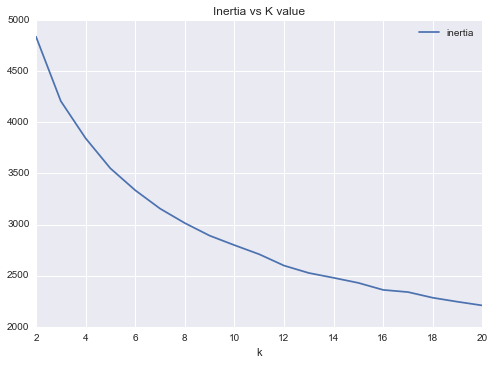

In [16]:
df.plot(x='k',y='inertia', title='Inertia vs K value')

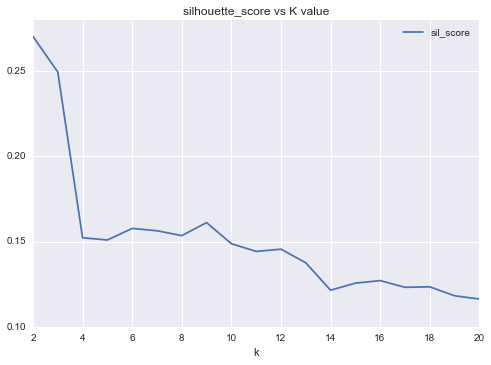

In [17]:
df.plot(x='k',y='sil_score', title='silhouette_score vs K value');

### Select parms
- elbow test hard to read. Small kink at 3.
- silhouette score takes big drop after 3.
- try 3 at first.
- try 4
- reset to 3

In [18]:
km = KMeans(n_clusters=3, n_init=20)
cluster_labels = km.fit_predict(X_train_std)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [19]:
cc = km.cluster_centers_
cc_scaled = scale.inverse_transform(cc)
df2 = pd.DataFrame(cc_scaled)
df2.columns = X.columns
df3 = df2.transpose()
df3



,0,1,2
n_pregnant,7.079,2.769,1.779
glucose,138.756,105.090,147.875
blood_pressure,77.895,68.618,75.403
skin_thick,30.577,26.174,36.984
insulin,173.405,129.736,219.980
bmi,33.212,29.621,39.942
pedigree,0.431,0.431,0.680
age,47.049,26.853,28.577
age_bmi,1548.309,795.155,1137.944
glu_age,6516.927,2804.526,4221.971


In [20]:
# Look at count in each cluster
unique, counts = np.unique(cluster_labels, return_counts=True)
n_digits =  len(unique)
print 'There are ', n_digits, ' clusters'
print np.asarray((unique, counts)).T

There are  3  clusters
[[  0 164]
 [  1 333]
 [  2 104]]


## 3 - Observations - Run k-Means on the dataset 
k-means has clustered into 3 groups. Value counts a little heavy on one group, but not bad.
- old and un-healty
- young and healty
- young and un-healthy

When Changed to 4 groups we had 
- Old un-healty
- young and healty
- youngish and sort of un-healthy
- youngish and un-healty

Not as defined

## 4 - Run PCA on the dataset and describe your results



In [21]:
pca = PCA(n_components=11, whiten=True)
pca.fit(X_train_std)
pca.explained_variance_

array([ 4.27169717,  1.9896729 ,  1.30299759,  0.93570021,  0.77781746,
        0.6690864 ,  0.53029081,  0.48048007,  0.01951785,  0.01348523,
        0.0092543 ])

In [22]:
pca.explained_variance_ratio_

array([ 0.38833611,  0.18087935,  0.11845433,  0.08506366,  0.07071068,
        0.06082604,  0.04820826,  0.04368001,  0.00177435,  0.00122593,
        0.0008413 ])

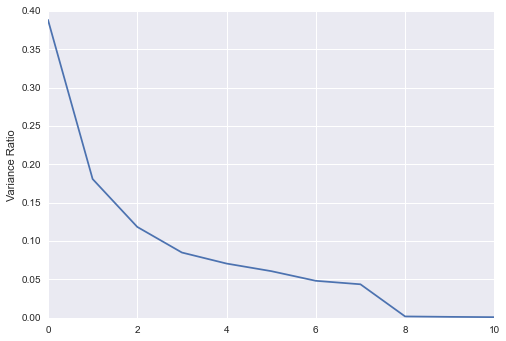

In [23]:
var = pca.explained_variance_ratio_
plt.plot(var)
plt.ylabel('Variance Ratio')
plt.show()

### Look for number of features that make up 80% of variance

In [24]:
sum = 0
i = 0
while sum < .80:
    sum = sum + pca.explained_variance_ratio_[i]
    i = i + 1
n_comps = i - 1
print 'Components: ', n_comps, ' Sum: ', sum

Components:  4  Sum:  0.843444121923


#### Result is 4 features. Down from the original 11.
- Also ran with 8. See comments at bottom)

In [25]:
pca = PCA(n_components=n_comps, whiten=True)
pca.fit(X_train_std)

PCA(copy=True, n_components=4, whiten=True)

In [32]:
pca = PCA(n_components=n_comps, whiten=True)
pca.fit(X_train_std)

PCA(copy=True, n_components=4, whiten=True)

### Trainsform the training and test data with the selected PCA model

In [33]:
# Transform the training data with the PCA model
X_train_pca = pd.DataFrame(pca.transform(X_train_std))

In [34]:
# Transform the testing data with the PCA model
%timeit X_test_pca = pd.DataFrame(pca.transform(X_test_std))

10000 loops, best of 3: 130 µs per loop


In [35]:
X_test_pca = pd.DataFrame(pca.transform(X_test_std))

In [36]:
X_test_pca.head(5)

,0,1,2,3
0,0.800,-0.321,-1.131,0.031
1,2.008,0.550,-1.062,-0.119
2,1.519,0.135,-0.730,-1.337
3,0.034,-1.102,1.281,1.595
4,0.780,-0.043,-0.950,1.526


In [37]:
# check sizes
print X_test_pca.shape, X_train_pca.shape

(151, 4) (601, 4)


## 5 - Use the cluster outputs you got from running k-means as a new feature. Rerun your "worst" and "best" model from HW2, including this new feature along with your old features. Describe your results.



## Add in the cluster features

In [38]:
# name is cluster_labels
# Turn Cluster labels into a dataFrame
cl_df = pd.DataFrame(cluster_labels, columns=['cluster'])
cl_df.head(2)

,cluster
0,1
1,1


In [39]:
cl_df['cluster'] = cl_df['cluster'].astype('category')

In [40]:
# use get_dummies to convert categoricals into binary features
cl_df = pd.get_dummies(cl_df)
cl_df.head(2)

,cluster_0,cluster_1,cluster_2
0,0.000,1.000,0.000
1,0.000,1.000,0.000


In [41]:
cl_df.drop('cluster_0', axis=1, inplace=True)
cl_df.head(2)

,cluster_1,cluster_2
0,1.000,0.000
1,1.000,0.000


In [42]:
X_train_df = pd.DataFrame(X_train_std, columns=X.columns)
X_train_df.head(1)

,n_pregnant,glucose,blood_pressure,skin_thick,insulin,bmi,pedigree,age,age_bmi,glu_age,glu_bmi
0,0.068,0.205,-0.199,-0.011,-0.019,0.281,-0.509,-0.771,-0.563,-0.492,0.271


In [43]:
# Create the training Dataframe, withe the cluster labels added
X_train_cl = pd.concat([X_train_df, cl_df], axis=1)
#X_train_cl = pd.concat([X_train_std, cl_df], axis=1)
X_train_cl.head(2)

,n_pregnant,glucose,blood_pressure,skin_thick,insulin,bmi,pedigree,age,age_bmi,glu_age,glu_bmi,cluster_1,cluster_2
0,0.068,0.205,-0.199,-0.011,-0.019,0.281,-0.509,-0.771,-0.563,-0.492,0.271,1.000,0.000
1,-1.137,-0.574,0.314,-0.011,-0.019,-2.053,0.322,-0.504,-1.338,-0.624,-1.406,1.000,0.000


In [44]:
X_test_df = pd.DataFrame(X_test_std, columns=X.columns)
X_test_df.head(1)

,n_pregnant,glucose,blood_pressure,skin_thick,insulin,bmi,pedigree,age,age_bmi,glu_age,glu_bmi
0,-0.233,0.563,-1.566,-0.011,-0.019,-0.996,-0.215,-0.949,-1.180,-0.499,-0.292


In [45]:
# Create the new test data frame with the cluster labels added
test_cl = km.predict(X_test_df)
test_cl_df = pd.DataFrame(test_cl, columns=['cluster'])
# add dummies
test_cl_df['cluster'] = test_cl_df['cluster'].astype('category')
test_cl_df = pd.get_dummies(test_cl_df)
test_cl_df.drop('cluster_0', axis=1, inplace=True)

X_test_cl = pd.concat([X_test_df, test_cl_df], axis=1)
X_test_cl.head(2)

,n_pregnant,glucose,blood_pressure,skin_thick,insulin,bmi,pedigree,age,age_bmi,glu_age,glu_bmi,cluster_1,cluster_2
0,-0.233,0.563,-1.566,-0.011,-0.019,-0.996,-0.215,-0.949,-1.180,-0.499,-0.292,1.000,0.000
1,-0.836,-1.581,-1.908,-2.281,-0.019,-1.378,-0.673,-1.038,-1.371,-1.257,-1.564,1.000,0.000


### k_Means and Neive Bayes  NOW - (Best Predictor) 

In [46]:
best_nb_cl = GaussianNB()
best_nb_cl.fit(X_train_cl, y_train)

GaussianNB()

/Users/jsmithson/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


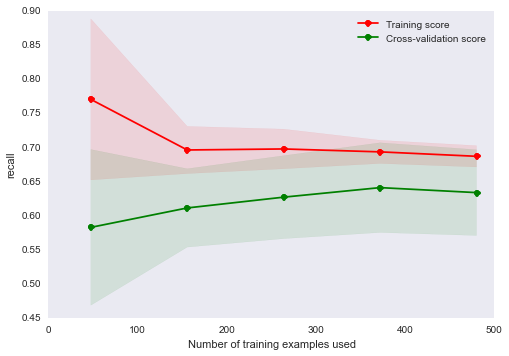

In [47]:
draw_learning_curve(best_nb_cl, X_train_cl, y_train, estimator_titles=['Learning Curve for NB'], 
                    cv=cv, scoring=scoring);

In [48]:
# Evaluate the decision tree using cross-validation; use recall as the evaluation metric.
scores = cross_val_score(best_nb_cl, X_train_cl, y_train, scoring=scoring, cv=cv)
print('CV Recall {}, Average Recall {}'.format(scores, scores.mean()))

CV Recall [ 0.51282051  0.74418605  0.63414634  0.68571429  0.63157895  0.65853659
  0.58064516  0.56521739  0.64705882  0.675     ], Average Recall 0.633490409537


In [49]:
# class predictions 
y_pred_class = best_nb_cl.predict(X_test_cl)

In [50]:
# calculate classification recall
recall_score = metrics.recall_score(y_test, y_pred_class)
recall_score

0.75862068965517238

In [51]:
# Get accuracy score for Test Data
acc_score = best_nb_cl.score(X_test_cl, y_test)
acc_score

0.74172185430463577

In [52]:
# BEST logreg time
time = %timeit -o best_nb_cl.predict(X_test_cl)
print time.best * 1000000

10000 loops, best of 3: 119 µs per loop
118.571090698


### k_Means and Logistical Regression (Best Predictor) - NOW (Worst Predictor # 2)

In [53]:
lr_cl = LogisticRegression()

In [54]:
# Tune Parameters using Gridsearch
#parameters = {'C': np.linspace(0.0000000001,2,20), 'penalty': ['l1', 'l2']}
parameters = {'C': np.linspace(0.01,.1,20), 'penalty': ['l1', 'l2']}
#parameters = {'penalty': ['l1', 'l2']}
clf_cl = GridSearchCV(lr_cl, parameters, cv=cv, scoring=scoring)
clf_cl.fit(X_train_cl, y_train)

GridSearchCV(cv=ShuffleSplit(601, n_iter=10, test_size=0.2, random_state=0),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([ 0.01   ,  0.01474,  0.01947,  0.02421,  0.02895,  0.03368,
        0.03842,  0.04316,  0.04789,  0.05263,  0.05737,  0.06211,
        0.06684,  0.07158,  0.07632,  0.08105,  0.08579,  0.09053,
        0.09526,  0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='recall', verbose=0)

In [55]:
clf_cl.best_params_

{'C': 0.01, 'penalty': 'l1'}

In [56]:
clf_cl.grid_scores_

[mean: 0.67620, std: 0.06742, params: {'penalty': 'l1', 'C': 0.01},
 mean: 0.56807, std: 0.08267, params: {'penalty': 'l2', 'C': 0.01},
 mean: 0.60572, std: 0.07210, params: {'penalty': 'l1', 'C': 0.014736842105263159},
 mean: 0.55881, std: 0.07672, params: {'penalty': 'l2', 'C': 0.014736842105263159},
 mean: 0.55579, std: 0.08203, params: {'penalty': 'l1', 'C': 0.019473684210526317},
 mean: 0.54948, std: 0.07141, params: {'penalty': 'l2', 'C': 0.019473684210526317},
 mean: 0.53338, std: 0.07557, params: {'penalty': 'l1', 'C': 0.024210526315789474},
 mean: 0.54191, std: 0.07081, params: {'penalty': 'l2', 'C': 0.024210526315789474},
 mean: 0.53044, std: 0.07674, params: {'penalty': 'l1', 'C': 0.028947368421052631},
 mean: 0.53715, std: 0.06791, params: {'penalty': 'l2', 'C': 0.028947368421052631},
 mean: 0.51655, std: 0.08412, params: {'penalty': 'l1', 'C': 0.033684210526315789},
 mean: 0.53727, std: 0.06291, params: {'penalty': 'l2', 'C': 0.033684210526315789},
 mean: 0.51440, std: 0.0

In [57]:
#best_lr_cl = clf_cl.best_estimator_

#### override the gridseearch and pick C myself

In [58]:
best_lr_cl = LogisticRegression(C=.038, penalty='l1')

In [59]:
# Run model with BEST Coefficients
best_lr_cl.fit(X_train_cl, y_train)

LogisticRegression(C=0.038, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [60]:
# coefficients close to 0 aren't very helpful
pd.DataFrame({'features': X_train_cl.columns, 'coefficients': best_lr_cl.coef_[0]})

,coefficients,features
0,0.143,n_pregnant
1,0.250,glucose
2,0.000,blood_pressure
3,0.000,skin_thick
4,0.000,insulin
5,0.000,bmi
6,0.025,pedigree
7,0.000,age
8,0.029,age_bmi
9,0.073,glu_age


<module 'matplotlib.pyplot' from '/Users/jsmithson/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

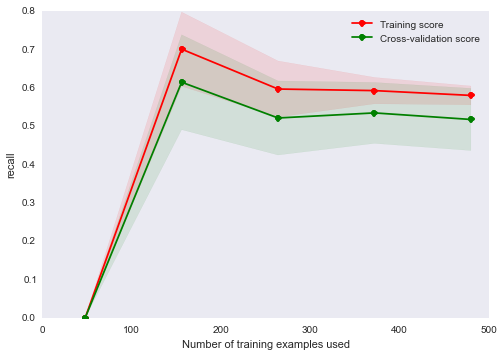

In [61]:
draw_learning_curve(best_lr_cl, X_train_cl, y_train, estimator_titles=['Learning Curve for RF'], 
                    cv=cv, scoring=scoring);
#plot_learning_curve(best_lr_cl, 'Learning Curve for logreg', best_lr_cl, y_train, cv=cv, scoring=scoring);

In [62]:
# class predictions (not predicted probabilities)
y_pred_class = best_lr_cl.predict(X_test_cl)

In [63]:
# calculate classification accuracy
recall_score = metrics.recall_score(y_test, y_pred_class)
recall_score

0.62068965517241381

In [64]:
best_lr_cl.score(X_test_cl, y_test)

0.78807947019867552

In [65]:
# BEST logreg time
time = %timeit -o best_lr_cl.predict(X_test_cl)
print time.best * 1000000

The slowest run took 4.04 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 47.5 µs per loop
47.522187233


### k_Means and Random Forest (Worst Predictor)

In [66]:
rf_cl = RandomForestClassifier()

In [67]:
parameters = {'n_estimators': range(1, 200, 10)}
clf = GridSearchCV(rf_cl, parameters, cv=cv)
clf.fit(X_train_cl, y_train)
clf.best_params_



{'n_estimators': 61}

In [68]:
best_rf_cl = clf.best_estimator_

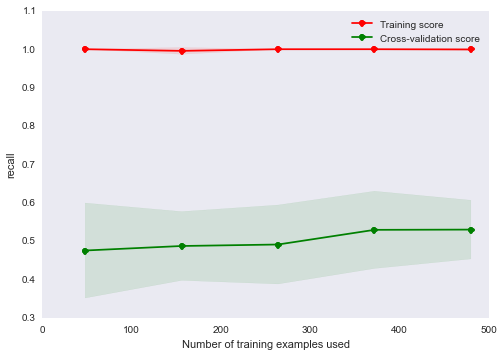

In [69]:
# Look at Learning Curve
draw_learning_curve(best_rf_cl, X_train_cl, y_train, estimator_titles=['Learning Curve for RF'], 
                    cv=cv, scoring=scoring);


In [70]:
# Evaluate the decision tree using cross-validation; use recall as the evaluation metric.
scores = cross_val_score(best_rf_cl, X_train_cl, y_train, scoring=scoring, cv=5)
print('CV score {}, Average score {}'.format(scores, scores.mean()))

CV score [ 0.57142857  0.51219512  0.53658537  0.56097561  0.63414634], Average score 0.563066202091


In [71]:
# class predictions 
y_pred_class = best_rf_cl.predict(X_test_cl)

In [72]:
# calculate classification recall
recall_score = metrics.recall_score(y_test, y_pred_class)
recall_score

0.62068965517241381

In [73]:
best_rf_cl.score(X_test_cl, y_test)

0.76158940397350994

In [74]:
# BEST rf time
time = %timeit -o best_rf_cl.predict(X_test_cl)
print time.best * 1000000

100 loops, best of 3: 3.22 ms per loop
3216.46213531


In [75]:
features = X_train_cl.columns
feature_importances = best_rf_cl.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df

,Features,Importance Score
10,glu_bmi,0.155
9,glu_age,0.126
1,glucose,0.126
8,age_bmi,0.108
5,bmi,0.092
6,pedigree,0.082
7,age,0.059
4,insulin,0.054
0,n_pregnant,0.051
2,blood_pressure,0.049


## 6 - Use the PCA outputs you got from running PCA above as your features. Rerun your "worst" and "best" model from HW2, with the PCA features instead of your old features. Describe your results.



### PCA and Neive Bayes - NOW (Best Predictor) 

In [76]:
best_nb_pca = GaussianNB()
best_nb_pca.fit(X_train_pca, y_train)

GaussianNB()

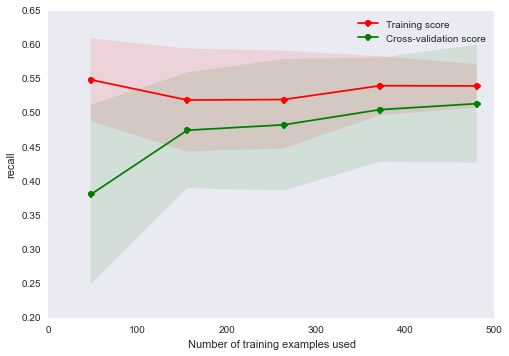

In [77]:
draw_learning_curve(best_nb_pca, X_train_pca, y_train, estimator_titles=['Learning Curve for NB'], 
                    cv=cv, scoring=scoring);

In [78]:
# Evaluate the decision tree using cross-validation; use recall as the evaluation metric.
scores = cross_val_score(best_nb_pca, X_train_pca, y_train, scoring=scoring, cv=cv)
print('CV Recall {}, Average Recall {}'.format(scores, scores.mean()))

CV Recall [ 0.35897436  0.60465116  0.3902439   0.62857143  0.60526316  0.48780488
  0.51612903  0.47826087  0.56862745  0.5       ], Average Recall 0.513852624152


In [79]:
# class predictions 
y_pred_class = best_nb_pca.predict(X_test_pca)

In [80]:
# calculate classification recall
recall_score = metrics.recall_score(y_test, y_pred_class)
recall_score

0.56896551724137934

In [81]:
# Get accuracy score for Test Data
acc_score = best_nb_pca.score(X_test_pca, y_test)
acc_score

0.72185430463576161

In [82]:
# BEST nb time
time = %timeit -o best_nb_pca.predict(X_test_pca)
print time.best * 1000000

10000 loops, best of 3: 111 µs per loop
110.6372118


### PCA and Logistical Regression (Best Predictor) - NOW (Worst Predictor # 2)

In [83]:
lr_pca = LogisticRegression()

In [84]:
# Tune Parameters using Gridsearch
parameters = {'C': np.linspace(0.0000000001,2,20), 'penalty': ['l1', 'l2']}
#parameters = {'penalty': ['l1', 'l2']}
clf_pca = GridSearchCV(lr_pca, parameters, cv=cv, scoring=scoring)
clf_pca.fit(X_train_pca, y_train)

GridSearchCV(cv=ShuffleSplit(601, n_iter=10, test_size=0.2, random_state=0),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-10,   1.05263e-01,   2.10526e-01,   3.15789e-01,
         4.21053e-01,   5.26316e-01,   6.31579e-01,   7.36842e-01,
         8.42105e-01,   9.47368e-01,   1.05263e+00,   1.15789e+00,
         1.26316e+00,   1.36842e+00,   1.47368e+00,   1.57895e+00,
         1.68421e+00,   1.78947e+00,   1.89474e+00,   2.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='recall', verbose=0)

In [85]:
clf_pca.best_params_

{'C': 0.10526315798947368, 'penalty': 'l1'}

In [86]:
best_lr_pca = clf_pca.best_estimator_

In [87]:
# Run model with BEST Coefficients
best_lr_pca.fit(X_train_pca, y_train)

LogisticRegression(C=0.10526315798947368, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0)

In [88]:
# coefficients close to 0 aren't very helpful
pd.DataFrame({'features': X_test_pca.columns, 'coefficients': best_lr_pca.coef_[0]})

,coefficients,features
0,-1.148,0
1,-0.242,1
2,-0.165,2
3,-0.056,3


<module 'matplotlib.pyplot' from '/Users/jsmithson/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

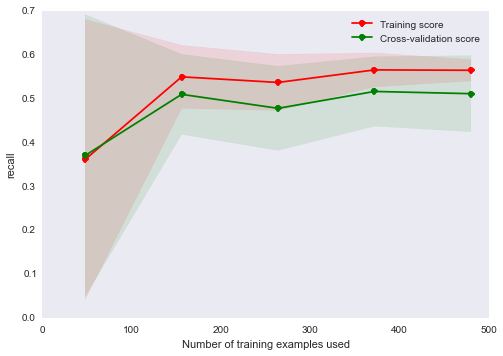

In [89]:

# Look at Learning Curve
draw_learning_curve(best_lr_pca, X_train_pca, y_train, estimator_titles=['Learning Curve for RF'], 
                    cv=cv, scoring=scoring);

#plot_learning_curve(best_lr_pca, 'Learning Curve for logreg', X_train_pca, y_train, cv=cv, scoring=scoring);

In [90]:
# class predictions (not predicted probabilities)
y_pred_class = best_lr_pca.predict(X_test_pca)

In [91]:
# calculate classification accuracy
recall_score = metrics.recall_score(y_test, y_pred_class)
recall_score

0.55172413793103448

In [92]:
best_lr_pca.score(X_test_pca, y_test)

0.73509933774834435

In [93]:
# BEST logreg time
time = %timeit -o best_lr_pca.predict(X_test_pca)
# BEST logreg time
print time.best * 1000000

The slowest run took 4.13 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 47.2 µs per loop
47.1989154816


### PCA and Random Forest (Worst Predictor)

In [94]:
rf_pca = RandomForestClassifier()

In [95]:
parameters = {'n_estimators': range(1, 200, 10)}
clf_pca = GridSearchCV(rf_pca, parameters, cv=cv)
clf_pca.fit(X_train_pca, y_train)
clf_pca.best_params_



{'n_estimators': 131}

In [96]:
best_rf_pca = clf_pca.best_estimator_

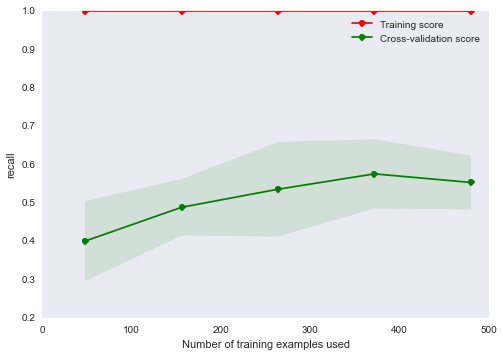

In [97]:
# Look at Learning Curve
draw_learning_curve(best_rf_pca, X_train_pca, y_train, estimator_titles=['Learning Curve for RF'], 
                    cv=cv, scoring=scoring);

In [98]:
# Evaluate the decision tree using cross-validation; use recall as the evaluation metric.
scores = cross_val_score(best_rf_pca, X_train_pca, y_train, scoring=scoring, cv=cv)
print('CV score {}, Average score {}'.format(scores, scores.mean()))

CV score [ 0.46153846  0.58139535  0.51219512  0.65714286  0.71052632  0.53658537
  0.58064516  0.47826087  0.54901961  0.5       ], Average score 0.556730910981


In [99]:
# class predictions 
y_pred_class = best_rf_pca.predict(X_test_pca)

In [100]:
# calculate classification recall
recall_score = metrics.recall_score(y_test, y_pred_class)
recall_score

0.53448275862068961

In [101]:
best_rf_pca.score(X_test_pca, y_test)

0.73509933774834435

In [102]:
# BEST rf time
time = %timeit -o best_rf_pca.predict(X_test_pca)
print time.best * 1000000

100 loops, best of 3: 6.81 ms per loop
6805.00030518


In [103]:
features = X_train_pca.columns
feature_importances = best_rf_pca.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df

,Features,Importance Score
0,0,0.413
1,1,0.220
2,2,0.202
3,3,0.166


## 7 - Give your conclusions on the use of k-Means and PCA on the Diabetes dataset

### Scoring

model|data|recall|accuracy|time
-----|----|------|--------|----
NB|original|.724|.755|150.24
|cluster(3)|.758|.741|118.24
|cluster(4)|.741|.755|138.71
|pca(4)|.569|.722|110.51
|pca(8)|.586|.735|114.75
LogReg|original|.603|.788|30.56
|cluster(3)|.621|.789|48.09
|cluster(4)|.621|.788|47.49
|pca(4)|.551|.735|47.37
|pca(8)|.569|.768|46.99
RF|original|.600|.762|10,072
|cluster(3)|.620|.761|3,216
|cluster(4)|.638|.755|779
|pca(4)|.534|.735|6,805
|pca(8)|.672|.781|2,310

# 7 - Conclusions

### Data
- Since we are looking for groups in the population that are likely to develop diabetes, clustering should be a help.
- There are several correlated features since they are 'halo' features. PCA may help reduce problems.

### Clustering
- Did have an effect on the scoring. The most was with Naive Bayes. With 3 clusters there was a jump from 72% to 76%.
- Smaller increases were seen in LogReg, even though the coefficients were very low.
- Random Forests had a small increase, even though the new features had low importance.
- Clustering improved the time of Naive Bayes and Random Forest (helping to decide quicker), but slowed down LogReg (more features)

### PCA
- Using 4 PCA components (80% of variance) actually hurt the performance of all the models. Going from 11 features to 4 just lost too much information. NB and RF had significant time reduction as expected.
- PCA did help reduce time, but at a pretty high price.
- Naive Bayes was hurt the most. Since it doesn't infer connections between features, reducing the number seems to have crippled it a lot.
- Using 8 PCA components (selected because of the drop off of the explained variance after 8 features) did help improve the performance of Random Forest. Perhaps it removed the influence of the highly correlated features.
- Naive Bayes and LogReg both still suffered.

### Final
- Grouping the population with clustering did help with prediction (best model + 5%) without a large time increase. It should be used in this case.

- It appears that the effect of adding the halo features in HW2 (which did add correlation) out weight the correlation reduction benefits of PCA. Our best model lost 19% in recall score with a time savings, but not enough to recommend using.